# Реализовать:

1. Прямые методы (гаусса, LU-разложение, методом Холецкого)(сделал)
2. Методы Якоби с параметром, SOR, SSOR. (сдела)
3. Блочные методы Якоби, SOR, SSOR.(не всё сдела) 
4. Метод минимальных поправок (сделал)
5. Метод сопряженных градиентов с предобуславливателем. (сделал)
6. Многосеточный метод(не сделано)

#### Работа выполнил 

Махмутов Ринат 

группа: 09-813

ивмиит-пми

In [1]:
import numpy as np
import pandas as pd
from numpy.core.defchararray import array
from scipy.linalg import norm, solve, block_diag

from typing import Union
import logging


import time

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(palette='deep', color_codes=True, font_scale=1.3)

# Прямые методы 

## LU - разложение 

Теорема. Любая невырожденная матрица $A$ может быть представлена в виде 
$$A=PLU,$$
где — $P$ - матрица перестановки, $L$ — нижнетреугольная матрица, $U$ — верхнетреугольная матрица

[Пример кода](http://rosettacode.org/wiki/LU_decomposition)

In [ ]:
def lu(A):
    """
    LU-разложение 
    """
    
    # количество строк
    n = A.shape[0]
    
    # Выделим место для P, L и U
    U = A.copy()
    L = np.eye(n, dtype=np.double)
    P = np.eye(n, dtype=np.double)
    
    # по строкам 
    for i in range(n):
        
        # 
        for k in range(i, n):
            # проверка что элемент близок к нулю
            if ~np.isclose(U[i, i], 0.0):
                break
                
            U[[k, k+1]] = U[[k+1, k]]
            P[[k, k+1]] = P[[k+1, k]]
            
        # Удалим запись ниже i-строки
        factor = U[i+1:, i] / U[i, i]
        # операции для L
        L[i+1:, i] = factor
        # операции для U, перевернув ряд 
        U[i+1:] -= factor[:, np.newaxis] * U[i]
        
    return P, L, U


Проверка

In [ ]:
A = np.array([[1, 3, 5.], 
              [2, 4, 7.], 
              [1, 1, 0.]])

print(A)
P, L, U = lu(A)

[[1. 3. 5.]
 [2. 4. 7.]
 [1. 1. 0.]]


In [ ]:
P@L@U

array([[1., 3., 5.],
       [2., 4., 7.],
       [1., 1., 0.]])

Получив $L$ и $U$, можем решить столько векторов правой части $\vec{b}$ нужно, используя следующий двухшаговый процесс. 

Сначала решим $\vec{y}=U\vec{x}$, а затем решим $L\vec{y} = \vec{b}$ для $\vec{y}$ с помощью прямой подстановки. 

In [ ]:
def forward(L, b):
    '''прямая подстановка'''
    
    # количество строк
    n = L.shape[0]
    
    # место для вектора решений
    y = np.zeros_like(b, dtype=np.double);
    
    # выполняем прямую подстановку.  
    # инициализируем первый ряд.
    y[0] = b[0] / L[0, 0]
    
    # пробегаем снизу вверх,
    # начиная с предпоследнего ряда, потому что 
    # решение последнего ряда было найдено на предыдущем шаге.
    for i in range(1, n):
        y[i] = (b[i] - np.dot(L[i,:i], y[:i])) / L[i,i]
        
    return y

Теперь решим $U\vec{x} = \vec{y}$ для $\vec{x}$ используя обратную подстановку.

In [ ]:
def backward(U, y):
    '''обратная подстановка'''
    
    # количество строк 
    n = U.shape[0]
    
    # место для вектора решений
    x = np.zeros_like(y, dtype=np.double);

    # выполняем обратную подстановку.  
    # инициализируем последний ряд.
    x[-1] = y[-1] / U[-1, -1]
    
    # пробегаем снизу вверх, 
    # начиная с предпоследнего ряда, 
    # потому что решение последнего ряда уже есть.
    for i in range(n-2, -1, -1):
        x[i] = (y[i] - np.dot(U[i,i:], x[i:])) / U[i,i]
        
    return x

Для факторизации потребуется дополнительный шаг перестановки вектора правой части $\vec{b}=P\vec{b}$ перед выполнением прямой подстановки для решения $\vec{y}$

In [ ]:
def lu_solve(A, b):
    '''решение LU'''
    
    P, L, U = lu(A)
    
    y = forward(L, np.dot(P, b))
    
    return backward(U, y)

Проверка

In [ ]:
A = np.round(10*np.random.rand(4,4))
b = np.array([1, 2, 3, 4.])

lu_solve(A, b)

array([ 0.24013722,  0.43996569,  0.19897084, -0.48799314])

In [ ]:
np.linalg.solve(A, b)

array([ 0.24013722,  0.43996569,  0.19897084, -0.48799314])

## Разложение Холецкого

Теорема. Любая симметричная положительно определённая матрица $A$ может быть представлена в виде
$$A=LL^T$$
где — $L$ нижнетреугольная матрица.

[Пример кода](http://rosettacode.org/wiki/Cholesky_decomposition)

In [ ]:
def cholesky(A):
    """
    Разложение Холецкого
    """
    
    # количество строк
    n = A.shape[0]
    
    # место для вектора решений
    L = np.zeros((n, n), dtype=np.double)
    
    for k in range(n):
        
        if ~np.isclose(L[k, k], 0.0):
                break
        
        L[k, k] = np.sqrt(A[k, k] - np.sum(L[k, :] ** 2))
        
        L[(k+1):, k] = (A[(k+1):, k] - L[(k+1):, :] @ L[:, k]) / L[k, k]
    
    return L

In [ ]:
A = np.array([[25, 15, -5.],[15, 18, 0.], [-5, 0, 11.]])
cholesky(A)

array([[ 5.,  0.,  0.],
       [ 3.,  3.,  0.],
       [-1.,  1.,  3.]])

In [ ]:
np.linalg.cholesky(A)

array([[ 1.41421356,  0.        ,  0.        ],
       [-0.70710678,  1.22474487,  0.        ],
       [ 0.        , -0.81649658,  1.15470054]])

In [ ]:
def cholesky_solve(A, b):
    '''решение Холецкого'''
    
    L = cholesky(A)
    y = forward(L, b)
    
    return backward(L.T, y)

In [ ]:
A = np.array([[25, 15, -5.],
              [15, 18, 0.], 
              [-5, 0, 11.]])

b = np.array([1, 2, 3.])
print(A)
cholesky_solve(A, b)

[[25. 15. -5.]
 [15. 18.  0.]
 [-5.  0. 11.]]


array([0.06814815, 0.05432099, 0.3037037 ])

In [ ]:
np.linalg.solve(A, b)

array([2.5, 4. , 3.5])

# Метод Гаусса

In [ ]:
def gauss_solve(A, b):
    '''решение методом Гаусса '''
    
    # Соединим матрицу A и 
    # правосторонний столбец вектор b в одну матрицу
    temp_mat = np.c_[A, b]
    
    # количество строк
    n = temp_mat.shape[0]
    
    # пробегаем по строкам 
    for i in range(n):
            
        #Найдем поворотный индекс, 
        # просматривая вниз по i-му столбцу из i-й строки, 
        # чтобы найти максимальную (по величине) запись.
        p = np.abs(temp_mat[i:, i]).argmax()
            
        # Переиндексируем индекс поворота, 
        # чтобы он был соответствующей записью во всей матрице, 
        # а не только в первой строке.
        p += i 
    
        # Поменяйте местами строки, 
        # чтобы максимальная запись стала поворотной
        if p != i:
            temp_mat[[p, i]] = temp_mat[[i, p]]
            
        # Исключите все записи ниже поворотной строки 
        factor = temp_mat[i+1:, i] / temp_mat[i, i]
        temp_mat[i+1:] -= factor[:, np.newaxis] * temp_mat[i]
                
    # Выделим места для вектора решений
    x = np.zeros_like(b, dtype=np.double);

    # Выполним обратную подстановку. 
    # Инициализируем с последней строкой.
    x[-1] = temp_mat[-1,-1] / temp_mat[-1, -2]
    
    # Пробежимся по рядам в обратном порядке (снизу вверх), 
    # начиная со второго и до последнего, 
    # т.к решение последнего ряда было найдено на предыдущем шаге.
    for i in range(n-2, -1, -1):
        x[i] = (temp_mat[i,-1] - np.dot(temp_mat[i,i:-1], x[i:])) / temp_mat[i,i]
        
    return x

# Итерационные методы

## Метод Якоби с параметром


Пусть $Ax=b$, где

$\begin{equation*}
A = 
\begin{pmatrix}
a_{1,1} & a_{1,2} & \cdots & a_{1,n} \\
a_{2,1} & a_{2,2} & \cdots & a_{2,n}\\
\vdots  & \vdots  & \ddots & \vdots  \\
a_{n,1} & a_{n,2} & \cdots & a_{n,n} 
\end{pmatrix}
,
x = 
\begin{pmatrix}
x_{1} \\
x_{2} \\
\vdots   \\
x_{n} 
\end{pmatrix}
,
b = 
\begin{pmatrix}
b_{1} \\
b_{2} \\
\vdots   \\
b_{n} 
\end{pmatrix}
\end{equation*}.$

Тогда $A$ можно разложить на диагональную компоненту $D$, нижнюю треугольную часть $L$ и верхнюю треугольную часть $U$:

$A=D+L+U$, где

$$\begin{equation*}
D = 
\begin{pmatrix}
a_{1,1} & 0 & \cdots & 0 \\
0 & a_{2,2} & \cdots & 0\\
\vdots  & \vdots  & \ddots & \vdots  \\
0 & 0 & \cdots & a_{n,n} 
\end{pmatrix}
,
L+U=
\begin{pmatrix}
0 & a_{1,2} & \cdots & a_{1,n} \\
a_{2,1} & 0 & \cdots & a_{2,n}\\
\vdots  & \vdots  & \ddots & \vdots  \\
a_{n,1} & a_{n,2} & \cdots & 0
\end{pmatrix}
\end{equation*}$$

Итерационное решение:

$$x^{(k+1)} = \omega D^{-1}(b- (L+U)x^{(k)}) + (1-\omega)x^{(k)}$$

In [ ]:
def weighted_jacobi(A, b, x, e=1e-10, max_iter = 500, w = 2./3):
    '''решение методм якоби с параметром'''
    
    count=0
    
    D = np.diag(np.diag(A))
    UL = A - D
    Dinv = np.linalg.inv(D)
    
    while(np.linalg.norm((np.dot(A, x) - b), ord=2)>e and count <= max_iter):
        x = w*(Dinv@(b - UL@x)) + (1-w)*x
        count += 1
        
    return x, count


In [ ]:
%%time
A = np.array([[10., -1., 2., 0.],
              [-1., 11., -1., 3.],
              [2., -1., 10., -1.],
              [0., 3., -1., 8.]])

b = np.array([6.0, 25.0, -11.0, 15.0])

x0 = np.zeros_like(b)

x, it = weighted_jacobi(A, b, x0)

print(f'x:{x}, итераций:{it}')
print(f'Проверим правильность решения Ax= {A@x}')

x:[ 1.  2. -1.  1.], итераций:44
Проверим правильность решения Ax= [  6.  25. -11.  15.]
CPU times: user 3.22 ms, sys: 1.04 ms, total: 4.26 ms
Wall time: 3.69 ms


## Метод Гаусса-Зейделя

Пусть $Ax=b$, где

$\begin{equation*}
A = 
\begin{pmatrix}
a_{1,1} & a_{1,2} & \cdots & a_{1,n} \\
a_{2,1} & a_{2,2} & \cdots & a_{2,1}\\
\vdots  & \vdots  & \ddots & \vdots  \\
a_{n,1} & a_{n,2} & \cdots & a_{n,n} 
\end{pmatrix}
,
x = 
\begin{pmatrix}
x_{1} \\
x_{2} \\
\vdots   \\
x_{n} 
\end{pmatrix}
,
b = 
\begin{pmatrix}
b_{1} \\
b_{2} \\
\vdots   \\
b_{n} 
\end{pmatrix}
\end{equation*}.$

Тогда $A$ можно разложить на диагональную компоненту $D$, нижнюю треугольную часть $L$ и верхнюю треугольную часть $U$:

$A=L_{*}+U$, где

$$\begin{equation*}
L_{*} = 
\begin{pmatrix}
a_{1,1} & 0 & \cdots & 0 \\
a_{2,1} & a_{2,2} & \cdots & 0\\
\vdots  & \vdots  & \ddots & \vdots  \\
a_{n,1} & a_{n,2} & \cdots & a_{n,n} 
\end{pmatrix}
,
U=
\begin{pmatrix}
0 & a_{1,2} & \cdots & a_{1,n} \\
0 & 0 & \cdots & a_{2,n}\\
\vdots  & \vdots  & \ddots & \vdots  \\
0 & 0 & \cdots & 0
\end{pmatrix}
\end{equation*}$$

Итерационное решение: 

$$x^{(k+1)} = L_{*}^{-1}(b - Ux^{(k)})$$
$$x^{(k+1)} = Tx^{(k)} + C, где$$
$$T = -L_{*}^{-1}U, C = L_{*}^-1b$$

In [ ]:
def gauss_seidel(A, b, x, e=1e-10, max_iter=500):
    '''решение методом Гаусса-Зейделя'''
    
    count = 0
    
    L, U = np.tril(A), np.triu(A, k=1)
    L_inv = np.linalg.inv(L)
    T = -L_inv@U
    C = L_inv@b

    while(np.linalg.norm((np.dot(A, x) - b), ord=2)>e and count <= max_iter):
        x = T@x + C
        count += 1
        
    return x, count 

In [ ]:
%%time
A = np.array([[10., -1., 2., 0.],
              [-1., 11., -1., 3.],
              [2., -1., 10., -1.],
              [0., 3., -1., 8.]])

b = np.array([6.0, 25.0, -11.0, 15.0])

x0 = np.zeros_like(b)

x, it = gauss_seidel(A, b, x0)

print(f'x:{x}, итераций:{it}')
print(f'Проверим правильность решения Ax= {A@x}')

x:[ 1.  2. -1.  1.], итераций:12
Проверим правильность решения Ax= [  6.  25. -11.  15.]
CPU times: user 1.84 ms, sys: 427 µs, total: 2.27 ms
Wall time: 2.31 ms


## SOR (Successive over-relaxation)

Итерационное решение:

$$x^{(k+1)} = (D - \omega L)^{-1}[(\frac{1}{\omega}D - D- U)x^{(k)} + b], \omega \in [0,2]$$

In [ ]:
def sor(A, b, x, w, e=1e-10, max_iter=1000):
    '''решение методом релаксации'''
    
    assert (w >= 0), f'параметр релаксации omega не в [0,2]'
    assert (w <= 2), f'параметр релаксации omega не в [0,2]'
    
    count = 0
    D = np.diag(np.diag(A))
    L, U = np.tril(A, k=-1), np.triu(A, k=1)
    M = D / w + L
    M_inv = np.linalg.inv(M)
    
    while(np.linalg.norm((np.dot(A, x) - b), ord=2)>e and count <= max_iter):
        x = M_inv@((D/w - D - U)@x + b)
        count += 1
        
    return x, count

In [ ]:
%%time
A = np.array([[4, -1, -6, 0],
              [-5, -4, 10, 8],
              [0, 9, 4, -2],
              [1, 0, -7, 5]])

b = np.array([2, 21, -12, -6])

x0 = np.zeros_like(b)

x, it = sor(A, b, x0, w=0.5)

print(f'x:{x}, итераций:{it}')
print(f'Проверим правильность решения Ax= {A@x}')

x:[ 3. -2.  2.  1.], итераций:60
Проверим правильность решения Ax= [  2.  21. -12.  -6.]
CPU times: user 6.42 ms, sys: 3.81 ms, total: 10.2 ms
Wall time: 8.22 ms


## SSOR (Symmetric successive over-relaxation)

[ресурс](http://www.netlib.org/linalg/html_templates/node58.html)

Симметричная матрица $A$, где 
$$A = D + L + L^T$$

можно решить итерационным методом:
$$P = (\frac{D}{\omega}+L)\frac{\omega}{2-\omega}D^{-1}(\frac{D}{\omega}+L)^T$$

$$x^{k+1} = x^{k} - P^{-1}(Ax^{k} - b), k \ge 0$$

In [ ]:
def ssor(A, b, x, e=1e-10, w=2/3, max_iter=1000):
    '''Метод симметричной последовательной верхней релаксации'''
    
    r = A@x - b
    count = 0
    D = np.diag(np.diag(A))
    L = np.tril(A)
    Q = np.dot(np.dot((D + w * L), np.linalg.inv(D)), np.transpose(D + w * L))
    z = np.dot(np.linalg.inv(Q),r)
    p = -(np.copy(z))
    
    while(np.linalg.norm((np.dot(A, x) - b), ord=2)>e and count <=max_iter):
        q = A@p
        a = np.dot(np.transpose(r),z)[0][0]/(np.dot(np.transpose(p),q)[0][0])
        x = x + a * p
        beta = 1 / (np.dot(np.transpose(r),z)[0][0])
        r = r + a * q
        z = np.dot(np.linalg.inv(Q),r)
        beta = beta * np.dot(np.transpose(r),z)[0][0]
        p = -z + beta * p
        count = count + 1
        
    return x, count

In [ ]:
%%time

# создаем симметричную матрицу 
N = 5
a = np.random.rand(N, N)
A = np.tril(a) + np.tril(a, k=-1).T

x = np.random.rand(N,1)
b = np.matmul(A,x) 
x0 = np.zeros((N,1))

# проверим при каком омега вычисления займут меньше всего итераций 
for i in np.linspace(0.0,2.0,num=20):
    Res = ssor(A, b, x0, e=1e-6, w=i)
    print(f'omega={i:.5f}, заняло {Res[1]} итераций')

omega=0.00000, заняло 5 итераций
omega=0.10526, заняло 5 итераций
omega=0.21053, заняло 5 итераций
omega=0.31579, заняло 5 итераций
omega=0.42105, заняло 5 итераций
omega=0.52632, заняло 5 итераций
omega=0.63158, заняло 5 итераций
omega=0.73684, заняло 5 итераций
omega=0.84211, заняло 5 итераций
omega=0.94737, заняло 6 итераций
omega=1.05263, заняло 6 итераций
omega=1.15789, заняло 6 итераций
omega=1.26316, заняло 6 итераций
omega=1.36842, заняло 6 итераций
omega=1.47368, заняло 6 итераций
omega=1.57895, заняло 6 итераций
omega=1.68421, заняло 6 итераций
omega=1.78947, заняло 6 итераций
omega=1.89474, заняло 6 итераций
omega=2.00000, заняло 6 итераций
CPU times: user 43.2 ms, sys: 9.99 ms, total: 53.2 ms
Wall time: 52.6 ms


In [ ]:
# посмотрим на матрицу с которой работали 
A

array([[0.96877569, 0.45301661, 0.11022378, 0.71500997, 0.08101911],
       [0.45301661, 0.10060168, 0.37065515, 0.7796662 , 0.69373135],
       [0.11022378, 0.37065515, 0.03931033, 0.70132925, 0.50610579],
       [0.71500997, 0.7796662 , 0.70132925, 0.60619664, 0.55966812],
       [0.08101911, 0.69373135, 0.50610579, 0.55966812, 0.600855  ]])

In [ ]:
# результат
Res[0]

array([[0.11933429],
       [0.88246746],
       [0.52831734],
       [0.40837605],
       [0.90377358]])

In [ ]:
# результат функцией из numpy 
np.linalg.solve(A, b)

array([[0.11933429],
       [0.88246746],
       [0.52831734],
       [0.40837605],
       [0.90377358]])

# Блочные методы

## Блочный метод Якоби

Блочный метод Якоби предполагает разбиение матрицы $A$ на блоки, а затем решение небольших систем, 2x2, 4x4, 8x8. У нас есть следующее выражение:

$$D_{block}x^{k+1}_{block} = (L_{block}+U_{block})x^k_{block} + b_{block}$$

Подробно, при размере блока 2x2 расписываем как:

$$
  \begin{bmatrix}
    a_{11} & a_{12} & & & & & \\
    a_{21} & a_{22} & & & & &\\
    & & a_{33} & a_{34} & & &\\
    & & a_{43} & a_{44} & & &\\
    & & & & \ddots& &\\
    & & & & & &\\
    & & & & &  a_{n-1, n-1} &  a_{n-1, n}\\
    & & & & & a_{n, n-1} & a_{n, n}\\
  \end{bmatrix} 
  \begin{bmatrix}
      x_1^{k+1}\\ 
      x_2^{k+1}\\
      x_3^{k+1}\\
      x_4^{k+1}\\
      \\
      \vdots\\
      x_{n_1}^{k+1}\\
      x_n^{k+1}\\
      \end{bmatrix}
  = 
  \begin{bmatrix}
    0& 0& -a_{13} & -a_{14} & \ldots & -a_{1n-1}&-a_{1n} \\
    0& 0& -a_{23} &-a_{24} & \ldots & -a_{2n-1}&-a_{2n} \\
    -a_{31}& -a_{32}& & & & &\\
    -a_{41}&-a_{42} & & & & &\\
    \vdots& \vdots& & & \ddots& &\\
    \vdots& \vdots& & &\ddots& & &\\
    -a_{n-1,1}& -a_{n-1,2}& & & & 0&0\\
    -a_{n1}&-a_{n,2} & & & & 0&0\\
  \end{bmatrix} 
    \begin{bmatrix}
      x_1^{k}\\ 
      x_2^{k}\\
      x_3^{k}\\
      x_4^{k}\\
      \\
      \vdots\\
      x_{n_1}^{k}\\
      x_n^{k}\\
      \end{bmatrix}
    + 
    \begin{bmatrix}
      b_1^{k}\\ 
      b_2^{k}\\
      b_3^{k}\\
      b_4^{k}\\
      \\
      \vdots\\
      b_{n_1}^{k}\\
      b_n^{k}\\
      \end{bmatrix}
  $$

Выполняя операцию в правой части системы, получаем:

$$
  \begin{bmatrix}
    a_{11} & a_{12} & & & & & \\
    a_{21} & a_{22} & & & & &\\
    & & a_{33} & a_{34} & & &\\
    & & a_{43} & a_{44} & & &\\
    & & & & \ddots& &\\
    & & & & & &\\
    & & & & &  a_{n-1, n-1} &  a_{n-1, n}\\
    & & & & & a_{n, n-1} & a_{n, n}\\
  \end{bmatrix} 
  \begin{bmatrix}
      x_1^{k+1}\\ 
      x_2^{k+1}\\
      x_3^{k+1}\\
      x_4^{k+1}\\
      \\
      \vdots\\
      x_{n_1}^{k+1}\\
      x_n^{k+1}\\
      \end{bmatrix}
  = 
    \begin{bmatrix}
      \hat{b_1}^{k}\\ 
      \hat{b_2}^{k}\\
      \hat{b_3}^{k}\\
      \hat{b_4}^{k}\\
      \\
      \vdots\\
      \hat{b_{n_1}}^{k}\\
      \hat{b_n^{k}}\\
      \end{bmatrix}
  $$

Так как у нас размер блока 2x2, следовательно для каждой итерации Якоби мы должны решать блочные системы вида:

$$
  \begin{bmatrix}
    a_{ii} & a_{ii+1}\\
    a_{i+1i} & a_{i+1i+1}\\
  \end{bmatrix} 
  \begin{bmatrix}
      x_i^{k+1}\\ 
      x_i+1^{k+1}\\
      \end{bmatrix}
  = 
    \begin{bmatrix}
      \hat{b_i}^{k}\\ 
      \hat{b_{i+1}}^{k}\\
      \end{bmatrix}
  $$
  
В реализации блочные системы решаются параллельно. Для этого матрица была переформирована в 3-мерную таблицу `D_blocked`, с размерами (p, размер блока, размер блока), где $p = \frac{n}{Размер Блока}$. Затем, обращаясь к элементам `D_blocked[:, i, i]`, мы получаем доступ к поворотным элементам всех блоков одновременно. 

In [4]:
def block_jacobi( A: np.array, b: np.array, block_size: int = 2, precision: np.float = 1e-6, max_iter: int = 2000, 
    verbose: bool = False, return_iter: bool  = False) -> Union[np.array, int]:
    """разбиваем матрицу A на квадратные блоки, а также вектор b на блоки одинакового размера и 
    решает Ax = b. Матрица A разбивается на две матрицы. D содержит диагональные блоки, а L и U
    верхняя и нижняя блочные треугольные матрицы. Параллельное решение блоков.
    Args:
        A (np.array): матрица A линейной системы
        b (np.array): вектор результат Ax
        block_size (int): размер блока
        precision (np.float, опционально): Допуск, если ниже 1e-6(по умолчанию) то прерываем.
        max_iter (int, опционально): максимальное количество итераций алгоритма. По умолчанию 2000.
        verbose (bool, опционально: если true, выводить результаты. По умолчанию False.
        return_iter (bool, опционально): возвращает решение x и количество итераций. По умолчанию False.
    return:
        Union[np.array, int]: решения линейной системы. Если return_iter = True, возвращается число 
        итераций.
    """
    
    start_time = time.time()
    iter_counter = 0
    error = np.finfo('double').max
    # размерность блоков
    p = A.shape[0] // block_size
    n = len(A)
    
    # Расчет диагональных блоков
    A_blocked = A.reshape(p, block_size, p, block_size).swapaxes(1, 2)
    D_blocked = np.diagonal(A_blocked, axis1=0, axis2=1).T
    
    # рассчитаем LU как диагональный блока A минус матрица A
    LU = block_diag(*D_blocked) - A
    
    # инициализация вектора x
    x = np.random.uniform(size=n)
    
    # запуск блочной итерации якоби
    while error > precision and iter_counter <= max_iter:
        # инициализация x^{k+1}
        x_next = np.zeros(shape=(p, block_size))
        
        # A_hat - диагональная форма блока (p, размер блока, размер блока)
        A_hat = D_blocked.copy()
        
        # вычислить b_hat и изменить форму на (p, размер блока)
        b_hat = LU @ x + b
        b_hat = b_hat.reshape(p, block_size)

        # начало параллельного вычисления 
        for i in range(block_size-1):
            # доступ ко всем опорным элементам
            pivot = A_hat[:, i, i]
            
            # исключить все строки, расположенные ниже поворотных элементов 
            for j in range(i+1, block_size):
                factor = A_hat[:, j, i] / pivot
                A_hat[:, j, :] -= np.multiply(A_hat[:, i, :].T, factor).T
                b_hat[:, j] -= b_hat[:, i] * factor
        
        # обратная подстановка
        # поэлементное деление
        x_next[:, block_size-1] = b_hat[:, block_size-1] / A_hat[:,block_size-1, block_size-1] 
        for k in range(block_size-2, -1, -1):
            # np.einsum('ij,ij->i',...,...) - это np.dot внутри блоков
            x_next[:, k] = (b_hat[:, k] - np.einsum('ij,ij->i', A_hat[:, k, k+1:], x_next[:, k+1:])) \
                           / A_hat[:, k, k] # поэлементное деление
        
        # изменить форму x_next на исходную
        x_next = x_next.reshape(n)
        # расситаем ошибку
        error = norm(x_next - x) / norm(x)
        x = x_next.copy()
        iter_counter += 1

    if error > precision:
        logging.warn(f'Алгоритм завершен т.к достиг максимального количество допустимых итераций. Error = {error}')
    end_time = time.time()
    
    if verbose:
        print(f'# найденное решение {x}')
        print(f'# Нашли за {iter_counter - 1} итераций, и заняло {(end_time - start_time):.4f} секунд')
        print(f'# абсолютная относительная погрешность: {error}')
    
    if return_iter:
        return x, iter_counter-1
    return x

## Блочный метод Гаусса-Зейделя

Этот метод схож по принципу действия с блочным методом Якоби. Матрица $A$ и векторы $x$ и $b$ разбиваются на блоки. Мы выполняем прямую подстановку, но для каждой итерации необходимо решить меньшую систему. Здесь нам не избежать итерационного характера задачи, поэтому мы не можем решать системы параллельно, так как для каждого блока $[x_i, x_{i+1}]$ предыдущий блок x $[x_{i-1}, x_{i-2}]$ должен быть уже вычислен.

Для решения блочных систем используем метод `solve` из scipy.

In [22]:
def block_gauss_seidel(A: np.array, b: np.array, block_size: int = 2, precision: np.float = 1e-6, max_iter: int = 2000, 
    verbose: bool = False, return_iter: bool  = False) -> Union[np.array, int]:
    """разбивает матрицу A на квадратные блоки, а также вектор b на блоки одинакового размера и 
    решает Ax = b. Матрица A разбивается на две матрицы. D содержит диагональные блоки, а L и U
    это треугольные матрицы верхнего и нижнего блоков.
    Args:
        A (np.array): матрица A линейной системы
        b (np.array): вектор результат Ax
        block_size (int): размер блока
        precision (np.float, опционально): Допуск, если ниже 1e-6(по умолчанию) то прерываем.
        max_iter (int, опционально): максимальное количество итераций алгоритма. По умолчанию 2000.
        verbose (bool, опционально: если true, выводить результаты. По умолчанию False.
        return_iter (bool, опционально): возвращает решение x и количество итераций. По умолчанию False.
    return:
        Union[np.array, int]: решения линейной системы. Если return_iter = True, возвращается число 
        итераций.
    """
    
    start_time = time.time()
    iter_counter = 0
    error = np.finfo('double').max
    p = A.shape[0] // block_size
    n = len(A)
    
    # построиv верхнюю треугольную матрицу
    U = -A.copy()
    for i in range(0,n,block_size):
        U[i:i+block_size, :i+block_size] = 0
    x = np.random.uniform(size=n)
    x_next = np.zeros(n)
    
    # начало итераций 
    while error > precision and iter_counter <= max_iter:
        # рассчитаем правую часть
        b_hat = U @ x + b
        x_next = np.zeros(n)
        
        # прямая подстановка
        x_next[0:block_size] = solve(A[:block_size, :block_size], b_hat[:block_size])
        for i in range(1, p):
            block_range = slice(i * block_size, (i + 1) * block_size)
            # получаем диагональный блок
            diag_block = A[block_range, block_range].copy()
            # рассчитаем наклон b
            b_tilted = b_hat[block_range] - A[block_range, :i * block_size] @ x_next[:i * block_size]
            # исключение для значений x. Используется метод solve из scipy.
            x_next[block_range] = solve(diag_block, b_tilted)

        error = norm(x_next - x) / norm(x)
        x = x_next.copy()
        iter_counter += 1
    
    end_time = time.time()

    if error > precision:
        logging.warn(f'Алгоритм завершен т.к достиг максимального количество допустимых итераций. Error = {error}')

    if verbose:
        print(f'# найденное решение\n {x}\n')
        print(f'# Нашли за {iter_counter - 1} итераций, и заняло {(end_time - start_time):.4f} секунд\n')
        print(f'# абсолютная относительная погрешность\n {error}')
        
    if return_iter:
        return x, iter_counter-1
    return x

# Создание матрицы

## Создадим дискретное уравнение Пуассона на сетке 64 x 64

![image.png](attachment:image.png)

In [ ]:
n = 64
m_poisson = np.zeros((n**2, n**2))

diag_ind = np.diag_indices(n**2)
m_poisson[diag_ind] = 4
lo_diag_ind_rows, lo_diag_ind_columns = np.diag_indices(n**2 - 1)
lo_diag_ind_rows = lo_diag_ind_rows + 1
m_poisson[lo_diag_ind_rows, lo_diag_ind_columns] = -1

up_diag_ind_rows, up_diag_ind_columns = np.diag_indices(n**2 - 1)
up_diag_ind_columns = up_diag_ind_columns + 1
m_poisson[up_diag_ind_rows, up_diag_ind_columns] = -1

# ниже диагонали
for i in range(n, n**2, n):
    m_poisson[i:i+n, i-n:i] = -1 * np.identity(n)

# выше диагонали
for i in range(0, n**2 -n, n):
    m_poisson[i:i+n, i+n:i+2*n] = -1 * np.identity(n)

b_poisson = np.ones(n ** 2)

In [ ]:
m_poisson.shape

(4096, 4096)

### Пуск блочных методов 

In [ ]:
block_jacobi(A=m_poisson, b=b_poisson, block_size=2, precision=1e-4, max_iter=5000, verbose=True, return_iter=False)

# найденное решение [2.42655327 4.35314462 5.97768221 ... 5.97768226 4.35314456 2.42655324]
# Нашли за 1799 итераций, и заняло 16.972615242004395 секунд
# абсолютная относительная погрешность: 9.983617618126231e-05


array([2.42655327, 4.35314462, 5.97768221, ..., 5.97768226, 4.35314456,
       2.42655324])

In [ ]:
block_gauss_seidel(A=m_poisson, b=b_poisson, block_size=2, precision=1e-4, max_iter=5000, verbose=True, return_iter=False)

# найденное решение [2.44834174 4.39670459 6.04301396 ... 6.05377137 4.40404936 2.45201556]
# Нашли за 1112 итераций, и заняло 141.87295627593994 секунд
# абсолютная относительная погрешность: 9.989159016448305e-05


array([2.44834174, 4.39670459, 6.04301396, ..., 6.05377137, 4.40404936,
       2.45201556])

## Эксперимент. Сравнение производительности
Чтобы сравнить производительность блочных итерационных методов, мы выполним по 3 прохода каждого из них и выведем среднее значение, чтобы иметь стабильный результат в случае колебаний. Кроме того, мы будем выполнять функции с одинаковой требуемой точностью, чтобы сравнить их на равной основе.

In [ ]:
def comparison_diagnostics(solver, name, T, b, *args):
    runtime = []
    errors = []
    runs = 3
    for i in range(runs):
        start_time = time.time()
        res = solver(T, b, *args)
        end_time = time.time()
        runtime.append(end_time - start_time)
        b_hat = T @ res
        error = norm(b - b_hat) / norm(b)
        errors.append(error)
    df = pd.DataFrame({'runtime':runtime, 'error':error})
    df['solver'] = name
    return df

In [ ]:
parallel_jacobi_2_block = comparison_diagnostics(block_jacobi,
                                                 'block_jacobi_2_block',
                                                 m_poisson, b_poisson, 2, 10**(-5), 10**6)

parallel_jacobi_4_block = comparison_diagnostics(block_jacobi,\ 
                                                 'block_jacobi_4_block',\
                                                 m_poisson, b_poisson, 4, 10**(-5), 10**6)

parallel_jacobi_8_block = comparison_diagnostics(block_jacobi,\ 
                                                 'block_jacobi_8_block',\ 
                                                 m_poisson, b_poisson, 8, 10**(-5), 10**6)

In [ ]:
gauss_seidel_2_block = comparison_diagnostics(block_gauss_seidel,\ 
                                              'block_gauss_seidel_2_block',\ 
                                              m_poisson, b_poisson, 2, 10**(-5), 10**6)

gauss_seidel_4_block = comparison_diagnostics(block_gauss_seidel,\ 
                                              'block_gauss_seidel_4_block',\ 
                                              m_poisson, b_poisson, 4, 10**(-5), 10**6)

gauss_seidel_8_block = comparison_diagnostics(block_gauss_seidel,\ 
                                              'block_gauss_seidel_8_block',\ 
                                              m_poisson, b_poisson, 8, 10**(-5), 10**6)

In [ ]:
comparisons = pd.concat([
    parallel_jacobi_2_block,
    parallel_jacobi_4_block,
    parallel_jacobi_8_block,
    gauss_seidel_2_block,
    gauss_seidel_4_block,
    gauss_seidel_8_block
])

agg = comparisons.groupby('solver').agg(avg_runtime = ('runtime', np.mean), error = ('error', np.mean)).reset_index()
agg.sort_values(by='avg_runtime', ascending=False, inplace=True)
agg

,solver,avg_runtime,error
0,block_gauss_seidel_2_block,252.792355,0.002786
1,block_gauss_seidel_4_block,125.464107,0.002332
2,block_gauss_seidel_8_block,68.788828,0.002069
5,block_jacobi_8_block,32.738612,0.004030
3,block_jacobi_2_block,31.589563,0.005271
4,block_jacobi_4_block,29.347793,0.004480


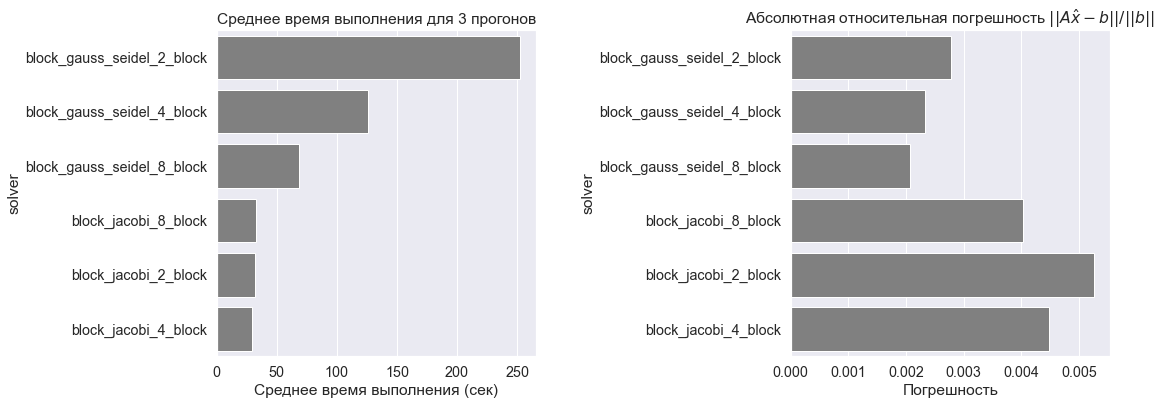

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(16,6))
fig.subplots_adjust(wspace=0.8)


sns.barplot(x='avg_runtime', y='solver', data=agg, color='grey', ax=axs[0])
axs[0].set_xlabel('Среднее время выполнения (сек)')
axs[0].title.set_text('Среднее время выполнения для 3 прогонов')

sns.barplot(x='error', y='solver', data=agg, color='grey', ax=axs[1])
axs[1].set_xlabel('Погрешность')
axs[1].title.set_text('Абсолютная относительная погрешность $||A\hat{x} - b|| / ||b\||$')
plt.show()

Глядя на результаты, мы можем заметить следующее:

- Самыми быстрыми методами являются блочные методы Якоби со средним временем выполнения ~1 секунда.
- Самым медленным методом является блочный метод Гаусса-Зейделя, где размер блока равен 2x2.
- Методы Якоби быстрые, но погрешность больше, чем у методов Гаусса-Зейделя.

Методы Якоби быстрее, потому что:
- блочный метод Якоби решает блочные системы параллельно, поэтому цикл for имеет фиксированное число итераций в зависимости от размера блока.



## Создадим дискретное уравнение Лапласа 

In [23]:
def laplacian_1d(n):
    return np.diag(2 * np.ones(n - 2)) + \
           np.diag(-np.ones(n - 3), 1) + \
           np.diag(-np.ones(n - 3), -1)


def laplacian_2d(n):
    return np.kron(np.eye(n - 2), laplacian_1d(n)) + \
           np.kron(laplacian_1d(n), np.eye(n - 2))


V = 1
n = 4

m_laplacian = -laplacian_2d(n)

b_laplacian = np.zeros_like(m_laplacian[:,1])
b_laplacian[:n-2] = np.repeat(-V, n - 2)
b_laplacian[-n+2:] = np.repeat(V, n - 2)

In [24]:
m_laplacian.shape

(4, 4)

In [26]:
import numpy as np

n = 5000
al = 0.5
A= np.zeros((n, n), 'float') 
for i in range(0, n):
  A[i,i] =2 
  if i>0:
    A[i,i-1] = - 1 + al 
  if i<n-1:
    A[i,i+1] = - 1 - al 

# print('A:\n', A)
A.shape

(5000, 5000)

In [27]:
B = np.zeros((n), 'float')
B[0] = 1 - al
B[n-1] = 1 + al
#print('B:\n', B)
B.shape

(5000,)

In [28]:
x = block_jacobi(A=A, b=B, 
             block_size=2, precision=1e-4, max_iter=10000, verbose=True, return_iter=False)

# найденное решение [1.00164024 1.0005968  0.99902512 ... 1.         1.         1.        ]
# Нашли за 5545 итераций, и заняло 107.5250 секунд
# абсолютная относительная погрешность: 9.661714700441861e-05


In [29]:
x

array([1.00164024, 1.0005968 , 0.99902512, ..., 1.        , 1.        ,
       1.        ])

In [35]:
Ax = np.around(A@x, decimals = 1)

In [36]:
np.array_equal(Ax, B)

True

In [21]:
b_laplacian

array([-1., -1., -1., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [18]:
block_gauss_seidel(A=m_laplacian, b=b_laplacian,
                   block_size=2, precision=1e-4, max_iter=5000, verbose=True, return_iter=False)

# найденное решение [ 0.47264357  0.64361222  0.71052572  0.73466425  0.7346507   0.71051389
  0.64358556  0.47262997  0.24694281  0.39121506  0.46378005  0.49339922
  0.49337578  0.46375959  0.39116893  0.24691926  0.12388869  0.21043197
  0.25992269  0.28166203  0.28163295  0.25989729  0.21037473  0.12385948
  0.03815497  0.06659487  0.08375646  0.09156362  0.09153317  0.08372987
  0.06653493  0.03812438 -0.03788672 -0.06606932 -0.0831108  -0.09082422
 -0.09085227 -0.08313529 -0.06612451 -0.03791489 -0.12365119 -0.20996666
 -0.25935104 -0.2810074  -0.28103011 -0.25937087 -0.21001136 -0.123674
 -0.24676414 -0.39086502 -0.46335001 -0.49290675 -0.49292227 -0.46336357
 -0.39089557 -0.24677973 -0.47254659 -0.64342221 -0.71029229 -0.73439693
 -0.73440453 -0.71029893 -0.64343718 -0.47255423]
# Нашли за 48 итераций, и заняло 0.0835 секунд
# абсолютная относительная погрешность: 9.34990033508656e-05


array([ 0.47264357,  0.64361222,  0.71052572,  0.73466425,  0.7346507 ,
        0.71051389,  0.64358556,  0.47262997,  0.24694281,  0.39121506,
        0.46378005,  0.49339922,  0.49337578,  0.46375959,  0.39116893,
        0.24691926,  0.12388869,  0.21043197,  0.25992269,  0.28166203,
        0.28163295,  0.25989729,  0.21037473,  0.12385948,  0.03815497,
        0.06659487,  0.08375646,  0.09156362,  0.09153317,  0.08372987,
        0.06653493,  0.03812438, -0.03788672, -0.06606932, -0.0831108 ,
       -0.09082422, -0.09085227, -0.08313529, -0.06612451, -0.03791489,
       -0.12365119, -0.20996666, -0.25935104, -0.2810074 , -0.28103011,
       -0.25937087, -0.21001136, -0.123674  , -0.24676414, -0.39086502,
       -0.46335001, -0.49290675, -0.49292227, -0.46336357, -0.39089557,
       -0.24677973, -0.47254659, -0.64342221, -0.71029229, -0.73439693,
       -0.73440453, -0.71029893, -0.64343718, -0.47255423])

# Перепишем метод SOR

In [ ]:
def SOR(A: np.array, b: np.array, omega: np.float, precision: np.float = 10**-6, max_iter: int = 2000, 
    verbose: bool = False, return_iter: bool  = False) -> Union[np.array, int]:
    """Реализация итерационного алгоритма Successive Overelaxation который решает задачу Ax=b.
    Матрица A разбивается на две матрицы. D содержит диагональные элементы, а LU
    недиагональные элементы, например, A = D-L-U.
    Args:
        A (np.array): матрица A линейной системы
        b (np.array): вектор результат Ax
        block_size (int): размер блока
        precision (np.float, опционально): Допуск, если ниже 1e-6(по умолчанию) то прерываем.
        max_iter (int, опционально): максимальное количество итераций алгоритма. По умолчанию 2000.
        verbose (bool, опционально: если true, выводить результаты. По умолчанию False.
        return_iter (bool, опционально): возвращает решение x и количество итераций. По умолчанию False.
    Возвращает:
        Union[np.array, int]: решения линейной системы. Если return_iter = True, возвращается число 
        итераций.
    """

    start_time = time.time()
    n = len(A)
    x = np.random.uniform(size=n)
    iter_counter = 0
    error = np.finfo('double').max
    
    # найдем нижние, верхние и диагональные матрицы
    L = - np.tril(A, -1)
    U = - np.triu(A, 1)
    D = np.diag(np.diag(A))
    
    # рассчитаем M и N
    M = 1/omega * (D - omega*L)
    N = (1-omega)/omega * D + U
    
    # начало итерации
    while error > precision and iter_counter <= max_iter:
        b_hat = N @ x + b
        x_next = np.zeros(n)
        # прямая подстановка 
        for i in range(n):
            x_next[i] = (b_hat[i] - M[i, :i] @ x_next[:i]) / M[i, i]
        error = norm(x_next - x) / norm(x)
        x = x_next.copy()
        iter_counter += 1
    
    end_time = time.time()
    
    if error > precision:
        logging.warn(f'Алгоритм завершен т.к достиг максимального количество допустимых итераций. Error = {error}')

    if verbose:
        print(f'# найденное решение {x}')
        print(f'# Нашли за {iter_counter - 1} итераций, и заняло {(end_time - start_time):.4f} секунд')
        print(f'# абсолютная относительная погрешность: {error}')
        
    if return_iter:
        return x, iter_counter - 1
    
    return x


## Найдем $\omega_{опт}$

In [ ]:
from tqdm import tqdm

runtimes = []
errors = []
omegas = np.arange(1,1.96,0.05)
iterations = []

for omega in tqdm(omegas):
    start_time = time.time()
    res, iter_ = SOR(m_poisson, b_poisson, omega=omega, verbose=False, max_iter=10000, return_iter=True)
    end_time = time.time()
    b_hat = T @ res
    error = norm(b_poisson - b_hat) / norm(b_poisson)
    errors.append(error)
    runtimes.append(end_time - start_time)
    iterations.append(iter_)

100%|███████████████████████████████████████████| 20/20 [13:55<00:00, 41.79s/it]


/Users/rinatmahmutov/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


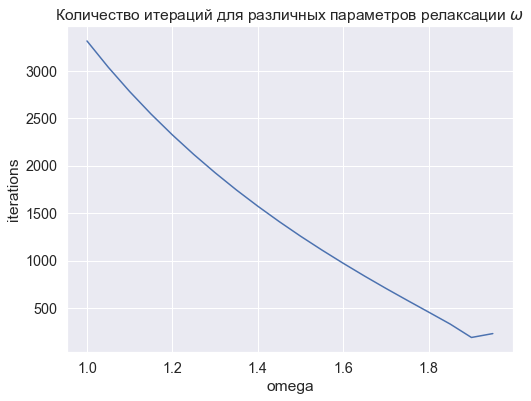

параметр омега оптимален между 1.8500000000000008 и 1.9500000000000008, занимает 190.0 итераций


In [ ]:
sor_results = pd.DataFrame({
    'omega': omegas,
    'runtimes': runtimes,
    'errors': errors,
    'iterations': iterations
    
})

fig, axs = plt.subplots(figsize=(8,6))
sns.lineplot(sor_results.omega, sor_results.iterations)
plt.title(f'Количество итераций для различных параметров релаксации $\omega$')
plt.show()

opt_index = sor_results.iterations.idxmin()
w_opt_range = sor_results.iloc[opt_index-1: opt_index+2].omega
min_iterations = sor_results.iloc[sor_results.iterations.idxmin()].iterations
print(f'параметр омега оптимален между {w_opt_range.min()} и {w_opt_range.max()}, занимает {min_iterations} итераций')

# Метод наискорейшего спуска, метод минимальных невязок и метод минимальных поправок.

Градиент рассматриваемого нами функционала имеет
вид:
$$\nabla \Phi (\vec{u}) = 2(A \vec{u} − \vec{f}$$
Чтобы найти решение СЛАУ, можно найти минимум соответствующего функционала. Так как направление градиента есть направление наибольшего возрастания функционала, то для нахождения минимума функционала нам нужно двигаться от некоторой начальной точки (начального приближения) в направлении, противоположном направлению градиента. Соответствующий итерационный процесс выглядит следующим образом:

$$\vec{u}^{(k+1)} = \vec{u}^{(k)} - \alpha_k \nabla \Phi(\vec{u}^{(k)})$$
Вектор
$$\vec{r_k} = A\vec{u}^{(k)} - \vec{f}$$
называется вектором невязки. Тогда
$$\nabla \Phi (\vec{u}^{(k)}) = 2\vec{r_k}$$
Методы наискорейшего спуска и минимальных невязок отличаются только выбором параметра $\alpha_k$:

$\alpha_k = \frac{1}{2} \frac{(\vec{r_k}, \vec{r_k})}{(A\vec{r_k},\vec{r_k})}$ — метод наискорейшего спуска;

$\alpha_k = \frac{1}{2} \frac{(A\vec{r_k}, \vec{r_k})}{(A\vec{r_k},A\vec{r_k})}$ — метод минимальных невязок

In [ ]:
def run_method(A, b, next_iter, x0, eps, history=False, return_num_iter=False):
    """
    Вспомогательная функция, которая прогоняет метод решения СЛАУ до сходимости.
    При указании параметров, печатает результаты на каждой промежуточной итерации
    или возвращает кол-во итераций.
    """
    x_prev = x0
    x_curr = next_iter(x_prev)
    if history:
        print("k=1. Current approximation: ", x_curr, end='. ')
        print("Error = {}.".format(norm(x_curr - x_prev)))
    k = 1
    while norm(x_curr - x_prev) >= eps:   
        k = k + 1
        x_prev = x_curr
        x_curr = next_iter(x_curr)  
        if history:
            print("k={}. Current approximation: ".format(k), x_curr, end='. ')
            print("Error = {}.".format(norm(x_curr - x_prev)))
    else:
        if history: print('')
    
    if return_num_iter: return x_curr, k
    return x_curr

## Метод минимальных невязок

In [ ]:
def min_residuals(A, b, eps, history=False, return_num_iter=False):
    
    def next_iter(xk):
        nonlocal A, b
        rk = np.dot(A, xk) - b
        Ark = np.dot(A, rk)
        return xk - np.dot(Ark, rk) / np.dot(Ark, Ark) * rk        
        
    return run_method(A, b, next_iter, tau0*b, eps, history, return_num_iter)   

## Метод минимальных поправок

In [ ]:
def min_correction(A, b, eps, history=False, return_num_iter=False):
    
    B_inv = np.diag(1 / np.diag(A))
    
    def next_iter(xk):
        nonlocal A, b, B_inv
        rk = np.dot(A, xk) - b
        wk = np.dot(B_inv, rk)
        Awk = np.dot(A, wk)
        vk = np.dot(B_inv, Awk)
        return xk - np.dot(Awk, wk) / np.dot(vk, Awk) * wk
        
    return run_method(A, b, next_iter, tau0*b, eps, history, return_num_iter)  

## Метод наискорейшего спуска

In [ ]:
def fastest_descent(A, b, eps, history=False, return_num_iter=False):
    
    def next_iter(xk):
        nonlocal A, b
        rk = np.dot(A, xk) - b
        Ark = np.dot(A, rk)
        return xk - np.dot(rk, rk) / np.dot(Ark, rk) * rk
    
    return run_method(A, b, next_iter, tau0*b, eps, history, return_num_iter) 

In [ ]:
# число обусловленности матрицы
# по умолчанию - отношение максимального
# и минимального собственных значений
print(np.linalg.cond(A))

# если считать самим по норме

ev = np.linalg.eigvals(np.dot(A.T, A))
print(ev)
R = np.sqrt(ev.max())

ev_inv = np.linalg.eigvals(np.dot(np.linalg.inv(A).T, np.linalg.inv(A)))
print(ev_inv)
r = np.sqrt(ev_inv.max())

print(R * r)

# тоже самим, но как отношение максимального и минимального с.ч.
evA = np.linalg.eigvals(A)
print(evA)
lmax = evA.max()
lmin = evA.min()
print(lmax / lmin)
xi = lmin / lmax
rho = (1 - xi) / (1 + xi)

7.142587013336615
[300.77669139   5.89566907  56.90744652  33.35389302]
[0.16961603 0.02998151 0.01757239 0.00332473]
7.142587013336625
[17.34291473  2.42809989  7.54370244  5.77528294]
7.142587013336617


(0.14000529473883944, 0.7543778166909078)

In [ ]:
tau0 = 2 / (lmax + lmin)

In [ ]:
def print_method_results(A, b, eps, meth):
    x_true = np.dot(np.linalg.inv(A), b)
    x_appr, k = meth(A, b, 1e-4, history=False, return_num_iter=True)
    print("{} method, # of iterations = {}.".format(meth.__name__, k))
    print("Aproximate solution: {}.".format(x_appr))
    print("Error = {}.".format(np.linalg.norm(x_appr - x_true)))
    print("Residual = {}.\n".format(np.linalg.norm(np.dot(A, x_appr)-b)))

In [ ]:
A = np.array([
    [ 3.77, 0.56, -1.45, 1.66],
    [ 0.56, 9.56,  5.23, 1.62],
    [-1.45, 5.23, 12.87, 1.99],
    [ 1.66, 1.62,  1.99, 6.89] 
])
 
b = np.array([8.94, -7.15, 10.45, 9.11])

x_true = np.dot(np.linalg.inv(A), b)
print("The exact solution: ", x_true)

The exact solution:  [ 3.22167612 -2.08251357  1.94807228  0.4730081 ]


In [ ]:
for meth in [min_residuals, min_correction, fastest_descent]:
    
    print_method_results(A, b, 1e-4, meth)

min_residuals_solution method, # of iterations = 33.
Aproximate solution: [ 3.2214591  -2.08247186  1.94798979  0.4731009 ].
Error = 0.000253482970391598.
Residual = 0.0006506547249753918.

min_correction_solution method, # of iterations = 17.
Aproximate solution: [ 3.22156126 -2.08245048  1.94798348  0.47305894].
Error = 0.00016626367303081824.
Residual = 0.0006025590479273847.

fastest_descent_solution method, # of iterations = 28.
Aproximate solution: [ 3.22148501 -2.08246002  1.94802326  0.47309634].
Error = 0.00022266679760321603.
Residual = 0.0006304426142418871.



# Метод сопряжённых градиентов

Данный метод является точным. Его суть заключается в том, чтобы выбирать параметры 𝛼𝑘 таким образом, чтобы каждый следующий вектор невязки был ортогонален всем предыдущим. Так как мы рассматриваем конечномерные пространства, то на последнем шаге вектор
невязки будет нулевым, так как в конечномерном пространстве число ненулевых взаимно ортогональных векторов конечно. Таким образом можно получить точное решение за конечное число итераций.
Приведем одно из возможных построений метода.

$$\vec{u}^{(1)} = (E - \tau_1 A) \vec{u}^{0} + \tau_1 \vec{f},$$

$$\vec{u}^{(k+1)} = \alpha_{k+1} (E - \tau_{k+1} A) \vec{u}^{(k)} + (1 - \alpha_{k+1})\vec{u}^{(k-1)} + \alpha_{k+1}\tau_{k+1} \vec{f},$$

где 

$$\alpha_1 = 1, \alpha_{k+1} = \lbrack 1 - \frac{1}{\alpha_k} \frac{\tau_{k+1}}{\tau_k} \frac{(\vec{r_k}, \vec{r_k})}{(\vec{r_{k-1}}, \vec{r_{k-1}})} \rbrack ^{-1}$$

[ресурс](https://towardsdatascience.com/complete-step-by-step-conjugate-gradient-algorithm-from-scratch-202c07fb52a8)

In [ ]:
import numpy as np
from numpy import matmul as matmul
from numpy.linalg import norm
import time


class LinearConjugateGradient:
    '''Метод сопряжённых градиентов'''
    def __init__(self, A, b, x=None):
        A = np.array(A)
        b = np.array(b)
        b = np.reshape(b, (-1, 1))
        assert np.shape(b)[0] == np.shape(A)[0]
        if not x:
            x = np.random.rand(np.shape(A)[1], 1)
        else:
            x = np.reshape(x, (-1, 1))
            assert np.shape(x)[0] == np.shape(A)[1]

        self.A = A
        self.b = b
        self.x = x

    def residual(self):
        '''невязка'''
        return np.matmul(self.A, self.x) - self.b

    _MAX_ITER, _TOLERANCE = 100000, .00000001
    
    def solve(self):
        '''реализация решения'''
        r = self.residual()
        p = -r 

        A = self.A
        b = self.b
        x = self.x

        k = 0

        time_start = time.time()
        
        while k <= self._MAX_ITER and norm(r) > self._TOLERANCE:
            pAp = matmul(matmul(p.T, A), p) # p_k^T A p_k
            alpha =  - matmul(r.T, p) / pAp  # ((r_k^T r_k) /pAp ) 
            x += alpha * p                # x_{k+1} = x_k + alpha_k p_k
            r = self.residual()
            beta = matmul(matmul(r.T, A), p) / pAp # - r_{k+1}^T A p_k/ pAp
            p = -r + beta * p 

            k += 1

        time_end = time.time()

        return x, (time_end - time_start)

In [ ]:
def tridiag(l=-1, c=-4, r=-1, size=3):
    '''трех-диагональная '''
    m = np.zeros([size, size])
    for i in range(size):
        for j in range(size):
            if i == j:
                m[i, j] = c
            elif i == j-1:
                m[i, j] = l
            elif i == j+1:
                m[i, j] = r
    return m


def hilb(size=3):
    '''матрица хилберта'''
    m = np.zeros([size, size])
    for i in range(size):
        for j in range(size):
            m[i, j] = i+j+1

    return m

In [ ]:
n = 6500
b = np.ones(n)

A = tridiag(size=n)
linear_CG_solver = LinearConjugateGradient(A, b)

x_star, time = linear_CG_solver.solve()
print(f'невязка: {norm(linear_CG_solver.residual())}, время: {time:.4f} секунд')

невязка: 5.330670607573773e-09, время: 1.2712 секунд


In [ ]:
n = 5000
b = np.ones(n)
A = hilb(size=n)
linear_CG_solver = LinearConjugateGradient(A, b)

x_start, delta_sec = linear_CG_solver.solve()
print(f'невязка: {norm(linear_CG_solver.residual())}, время: {time:.4f} секунд')

residual:  5.94201726454203e-09 , solved in 0.12166976928710938 seconds
